Optimal Mean Reversion Trading: Mathematical Analysis And Practical Applications by Tim Siu-tang Leung, Xin Li

Video:  <a href = "https://youtu.be/vHzlZECzyPE">What is a pairs trade</A><br>
Video:  <a href="https://youtu.be/GdqVY1kZ4XI">Maximum Likelihood Estimation with Ornstein-Uhlenbeck (part 1)</A><br>
Video:  <a href="https://youtu.be/3906CWKhLqQ">Maximum Likelihood Estimation with Ornstein-Uhlenbeck (part 2)</A><br>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import MultiCursor,Button
%matplotlib inline

## Ornstein-Uhlenbeck Process and Parameter Determination

$$ dX_t = \mu(\theta - X_t) dt + \sigma dW_t$$


When we wish to simulate this process, we use a differencing formula:
$$X_i - x_{i-1} = \mu(\theta - X_i) (t_i - t_{i-1}) + \sigma\sqrt{t_i - t_{i-1}}W_t$$

The optimal parameters can be calculated analytically.

First define

$$
X_x = \sum_{i=1}^N x_{i-1}
$$

$$
X_y = \sum_{i=1}^N x_i
$$

$$
X_{xx} = \sum_{i=1}^N (x_{i-1})^2
$$

$$
X_{xy} = \sum_{i=1}^N x_{i-1} x_i
$$

$$
X_{yy} = \sum_{i=1}^N (x_i)^2
$$

The optimal parameters are given by,


$$
\theta^* = \frac{X_y X_{xx} - X_x X_{xy}}
{N(X_{xx} - X_{xy}) - (X_x^2 - X_xX_y)}
$$

$$
\mu^* = -\frac{1}{\Delta t} \ln\left(
\frac{X_{xy} - \theta^*X_x - \theta^*X_y + N(\theta^*)^2}
{X_{xx} - 2\theta^*X_x + N(\theta^*)^2}\right)
$$


\begin{multline}
(\sigma^*)^2 = \frac{2\mu^*}{N(1-e^{-2\mu^*\Delta t})} (X_{yy} - 2e^{-\mu^*\Delta t} X_{xy} + e^{-2\mu^*\Delta t}X_{xx} \\
- 2\theta^* (1-e^{-\mu^*\Delta t})(X_y - e^{-\mu^*\Delta t})X_x + N(\theta^*)^2(1-e^{-\mu^*\Delta t})^2)
\end{multline}

In [2]:
def log_likelihood( parameters, S, dt ):
    theta = parameters[0]
    mu = parameters[1]
    sigma = parameters[2]
    
    sigma0 = sigma**2 * (1 - np.exp(-2*mu*dt)) / (2 * mu)
    sigma0 = np.sqrt( sigma0 )
        
    N = S.size
    
    term1 = -0.5 * np.log(2 * np.pi)
    term2 = -np.log(sigma0)
    
    prefactor = -1 / (2 * N * sigma0**2)
    sum_term = 0
    for i in range( 1, N ):
        x2 = S[i]
        x1 = S[i-1]
        
        sum_term = sum_term + (x2 - x1 * np.exp(-mu*dt) - \
                   theta * (1-np.exp(-mu*dt)))**2
    
    f = (term1 + term2 + prefactor * sum_term)

    return f

def calculate_parameters(x, dt):
    
    N =x.size
    
    Xx  = np.sum(x[0:-1])
    Xy  = np.sum(x[1:])
    Xxx = np.sum(x[0:-1]**2)
    Xxy = np.sum(x[0:-1] * x[1:])
    Xyy = np.sum(x[1:]**2)

    theta0 = (Xy * Xxx - Xx * Xxy) / (N * (Xxx - Xxy) - (Xx**2 - Xx * Xy) )

    mu0 = (Xxy - theta0 * Xx - theta0 * Xy + N * theta0**2) / \
        (Xxx - 2 * theta0 * Xx + N * theta0**2)
    mu0 = -1 / dt * np.log(mu0)

    prefactor = 2 * mu0 / (N*(1-np.exp(-2*mu0*dt)))
    term = Xyy - 2*np.exp(-mu0*dt) * Xxy + np.exp(-2*mu0*dt) * Xxx - 2*theta0*(1-np.exp(-mu0*dt)) * (Xy - Xx * np.exp(-mu0*dt)) + N * theta0**2 * ( 1-np.exp(-mu0 * dt))**2

    sigma02 = prefactor * term
    sigma0 = np.sqrt(sigma02)
    
    return theta0, mu0, sigma0

##  Pairs Price

Our $X$ values will be the price of the pair over some range of time.

$$
X^{\alpha, \beta}_t = \alpha S_t^{(1)} - \beta S_t^{(2)}
$$

where $S_t^{(1)}$ and $S_t^{(2)}$ are the prices of stock one and two, respectively.  Likewise, $\alpha$ and $\beta$ are the numbers of shares of $S^{(1)}$ and $S^{(2)}$ owned.

For each potential pair, in other words for different values of $\alpha$ and $\beta$, we will use historical data to generate the OU parameters.

We will then sweep the values for $\alpha$ and $\beta$ (actually the ratio) and find the values that maximize the log likelihood.  We fix $\alpha$ and sweep $\beta$.

If we put $A$ dollars in $S^{(1)}$ we have
$$
\alpha = \frac{A}{S_0^{(1)}}.
$$

$$
\beta = \frac{B}{S_0^{(2)}}.
$$

The authors do the calculation in dollar amounts.  Since we only care about a ratio, we can set $A=1$.  When w do the calculation, we can sweep the parameters by taking a range of the ratio $B/A$.  We will take $B/A = 0.001 \ldots 1$.

##  Example

Our pairs will be GLD-GDX, and GLD-SLV.

Let's load in the GLD, GDX, and SLV data.

Data fro Aug 2011 to May 2012

$N = 200$, and $\Delta t = 1 / 252$.


In [23]:
GDX = pd.read_csv('GDX_historical.csv')
GLD = pd.read_csv('GLD_historical.csv')
SLV = pd.read_csv('SLV_historical.csv')

gld = np.log(GLD['Adj Close'].to_numpy())
gdx = np.log(GDX['Close'].to_numpy())
slv = np.log(SLV['Close'].to_numpy())

print('Numbner of data points in file = ', gld.size)

#  The book uses only 200 points, so we'll trim our data down.
#  I wrote this so you can easily adjust which 200 points are used.
#  Obviously, don't go beound the length of the raw data.

M = 3
gld = gld[M:M + 200]
gdx = gdx[M:M + 200]
slv = slv[M:M + 200]

N = gld.size
dt = 1/252
dt = 1/200

Numbner of data points in file =  210


In [24]:
B_over_A = np.linspace(0.001, 1, 1000)
likelihood_gld_gdx = []

for value in B_over_A:
    alpha = 1 / gld[0]
    
    beta = value / gdx[0]
    
    X = alpha * gld - beta * gdx
    
    parameters = calculate_parameters(X, dt)
    likelihood_gld_gdx.append(log_likelihood(parameters, X, dt))
    
likelihood_gld_slv = []

for value in B_over_A:
    alpha = 1 / gld[0]
    
    beta = value / slv[0]
    
    X = alpha * gld - beta * slv

    parameters = calculate_parameters(X, dt)
    likelihood_gld_slv.append(log_likelihood(parameters, X, dt))

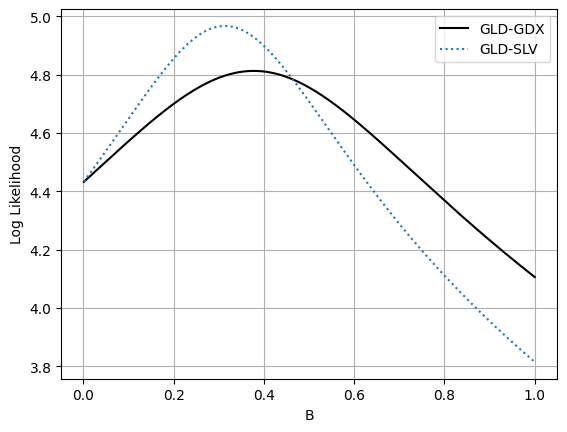

In [25]:
#  We want to plot things in terms of B, but we set A = 1 above so B/A = B.
#  I am just making it explicit here for clarity.
B = B_over_A * 1
plt.plot(B, likelihood_gld_gdx, 'k', label = 'GLD-GDX')
plt.plot(B, likelihood_gld_slv, ':', label = 'GLD-SLV')
plt.xlabel('B')
plt.ylabel('Log Likelihood')
plt.grid()
plt.legend()

Now we’ll figure out which value of $B$ gives the maximum log likelihood.  There are better ways to do this, but this is probably the simplest if our $B$-vector  has a high enough density of points.  We’ll just find the maximum value of the log likelihood, find which index corresponds to that vector, and pull out the $B$-value with that index.

The book gets these values:
GLD-GDX: 0.454<br>
GLD-SLV:  0.493

We get numbers that are close, but slightly different.

In [26]:
V = np.amax(likelihood_gld_gdx)
ind = np.where(likelihood_gld_gdx == V)
ind = ind[0]
B = B[ind][0] 

# print('GLD-GDX: ', B[ind][0] )

# #  Do the same with for the pair with SLV
# V = np.amax(likelihood_gld_slv)
# ind = np.where(likelihood_gld_slv == V)
# ind = ind[0]
# print('GLD-SLV: ', B[ind][0] )

In [27]:
B


0.378

In [28]:
alpha = 1/gld[0]
beta = B/gdx[0]

In [36]:
Xt = np.exp(alpha*gld) - np.exp(beta*gdx)

In [37]:

parameters= calculate_parameters(Xt, dt)

theta = parameters[0]
mu = parameters[1]
sigma = parameters[2]
parameters

(1.313796378783222, 0.4399416393431504, 0.08523662518870707)

In [38]:
Yt = (np.sqrt(2*mu)/sigma)*(Xt-theta)

In [39]:
def calculate_zscore(spread,halflife):
        ''' Using rolling MEAN and STANDARD Deviation Calculate the Distribution ZSCORE'''
        z_score_window = halflife
        spread = spread[~np.isnan(spread)]

        df = pd.DataFrame(spread)        

        mean = df.rolling(center=False, window=z_score_window).mean()
        std = df.rolling(center=False, window=z_score_window).std()
        x = df.rolling(center=False, window=1).mean()
        df["ZSCORE"] = (x - mean) / std
        # print(df)
        return df["ZSCORE"].astype(float).values

In [40]:
zscore = calculate_zscore(Xt,int(mu) )

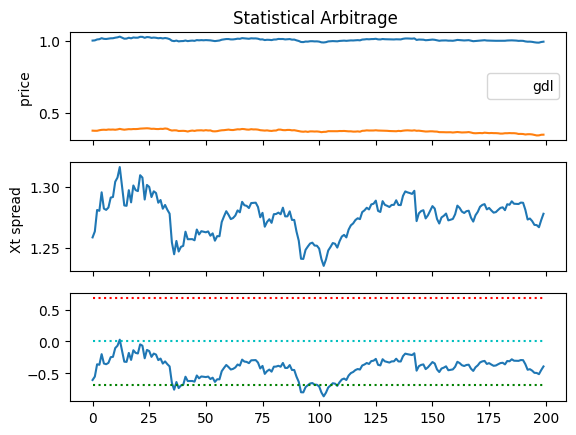

In [41]:
fig, (ax1, ax2,ax3) = plt.subplots(3, sharex=True)
# plt.figure(figsize=(8,6),dpi=200)

plt.multi = MultiCursor(fig.canvas, (ax1, ax2, ax3), color='r', lw=1)
# plt.subplot(3, 1, 1)
ax1.set_title(f"Statistical Arbitrage ")        
# plt.xlim([0, 200])
ax1.legend(['gdl','gdx'])
ax1.set_ylabel("price ")
ax1.plot(alpha*gld )
ax1.plot(beta*gdx)


ax2.set_ylabel("Xt spread ")
ax2.plot(Xt)





# # plt.subplot(3, 1, 3)
# plt.xlim([0, 200])

ax3.plot(Yt)


min_z = np.min(Yt)*0.8
max_z = np.max(Yt)*0.8

if np.abs(min_z) > max_z:
    max_z = min_z


up_green_line = np.full(len(zscore),max_z, dtype=float)
down_red_line = np.full(len(zscore), -max_z, dtype=float)
zero_line = np.full(len(zscore), 0, dtype=int)


ax3.plot(up_green_line,color = 'g', linestyle = 'dotted')
ax3.plot(down_red_line,color = 'r', linestyle = 'dotted')
ax3.plot(zero_line,color = 'c', linestyle = 'dotted')


# ax3.set_ylabel(f"KFMA max= {max_z} min_z= {min_z} ")

# fig.savefig(f'Data/Plots/{symbol}_plot_zscore_multi.png')

def onclick(event):
    x1,y1 = event.xdata,event.ydata
    print(x1,y1)

fig.canvas.mpl_connect('button_press_event',onclick)

plt.show()



In [42]:
Yt

array([-0.60392158, -0.55033099, -0.35763702, -0.36525596, -0.19909935,
       -0.34562828, -0.356847  , -0.33549428, -0.246655  , -0.2410317 ,
       -0.10391571, -0.06658895,  0.02757551, -0.14899353, -0.31706463,
       -0.3203067 , -0.18009253, -0.28926483, -0.13777043, -0.17942693,
       -0.18838736, -0.04559071, -0.06692045, -0.26379487, -0.13297555,
       -0.15069526, -0.24151658, -0.18994204, -0.20565082, -0.29251409,
       -0.26830089, -0.34645534, -0.31267471, -0.35593702, -0.39120048,
       -0.64849248, -0.75540077, -0.63557189, -0.73067645, -0.68886409,
       -0.67985479, -0.55259375, -0.62034622, -0.61982577, -0.61937975,
       -0.62988597, -0.53330422, -0.57762705, -0.54822513, -0.55353595,
       -0.55811561, -0.55020492, -0.58868969, -0.56753701, -0.63341071,
       -0.59245289, -0.59350752, -0.46596151, -0.41511681, -0.36875748,
       -0.40109029, -0.43955568, -0.42986938, -0.40765028, -0.36134169,
       -0.37852945, -0.28473515, -0.31513116, -0.32086765, -0.34